In [1]:
CODE_DIR = "/home/cbarkhof/fall-2021"
ANALYSIS_DIR = f"{CODE_DIR}/analysis/analysis-files"
CHECKPOINT_DIR = f"{CODE_DIR}/run_files/checkpoints"

N_UNCONDITIONAL_SAMPLES = 2000
N_VALID_CONDITIONAL_SAMPELS = 2000
N_TRAIN_SAMPLES = 2000

COND_SAMPLE_BATCH_SIZE = 200

SAMPLE_FILE = f"generative-samples.pt"
CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"

DEVICE = "cuda:0"

import sys; sys.path.append(CODE_DIR)

import torch

from analysis.language_analysis.analysis_steps import make_run_overview_df, get_test_validation_loader
from analysis.MNIST_analysis.analysis_utils import get_n_data_samples_x_y
from utils import load_checkpoint_model_for_eval

In [4]:
from dataset_dataloader import LanguageDataset
from arguments import prepare_parser

config = prepare_parser(jupyter=True, print_settings=False)
for k, v in vars(config).items():
    print(k, v)

config_file None
objective VAE
beta_beta 1.0
free_bits 5.0
free_bits_per_dimension True
mdr_value 16.0
mdr_constraint_optim_lr 0.001
info_lambda_1_rate 1.0
info_lambda_2_mmd 100.0
rate_constraint_val 16.0
rate_constraint_rel eq
rate_constraint_lr 0.001
mmd_constraint_val 0.005
mmd_constraint_rel le
mmd_constraint_lr 0.001
batch_size 32
max_steps 1000000
max_epochs 120
eval_ll_every_n_epochs 1
gen_opt adam
gen_lr 1e-05
gen_l2_weight 0.0001
gen_momentum 0.0
inf_opt adam
inf_lr 1e-05
inf_l2_weight 0.0001
inf_momentum 0.0
max_gradient_norm 1.0
iw_n_samples 50
latent_dim 32
decoder_network_type strong_distil_roberta_decoder
decoder_MADE_gating True
decoder_MADE_gating_mechanism 0
strong_roberta_decoder_embedding_dropout False
strong_roberta_decoder_embedding_dropout_prob 0.2
decoder_MADE_hidden_sizes 200-220
encoder_network_type distil_roberta_encoder
encoder_MADE_hidden_sizes 200-220
q_z_x_type independent_gaussian
p_z_type isotropic_gaussian
mog_n_components 10
data_dir /home/cbarkhof/fal

In [5]:
config.max_seq_len = 500
config.batch_size = 10
config.language_dataset_name = "yahoo_answer"

dataset = LanguageDataset(args=config)

New pre-processing


W1215 13:04:37.576871 23010757607168 builder.py:539] Reusing dataset yahoo_answers_topics (/home/cbarkhof/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902)
W1215 13:04:38.559062 23010757607168 builder.py:539] Reusing dataset yahoo_answers_topics (/home/cbarkhof/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902)
W1215 13:04:39.019777 23010757607168 builder.py:539] Reusing dataset yahoo_answers_topics (/home/cbarkhof/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902)


  0%|          | 0/140 [00:00<?, ?ba/s]

convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
convert to features


  0%|          | 0/6 [00:00<?, ?ba/s]

convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
--> data_path /home/cbarkhof/fall-2021/data/yahoo_answer-roberta-base-seqlen-500
Saved split validation in /home/cbarkhof/fall-2021/data/yahoo_answer-roberta-base-seqlen-500/validation


  0%|          | 0/6 [00:00<?, ?ba/s]

convert to features
convert to features
convert to features
convert to features
convert to features
convert to features
--> data_path /home/cbarkhof/fall-2021/data/yahoo_answer-roberta-base-seqlen-500
Saved split test in /home/cbarkhof/fall-2021/data/yahoo_answer-roberta-base-seqlen-500/test


In [10]:
lengths = []
for i, batch in enumerate(dataset.train_loader(batch_size=20)):
    print(f"{i:2d}/20", end="\r")
    lengths.append(batch["attention_mask"].sum(dim=-1)-2)
    if i == 100:
        break
lengths = torch.cat(lengths)

(array([1069.,  434.,  216.,   88.,   69.,   42.,   30.,   19.,    8.,
          45.]),
 array([  0. ,  49.8,  99.6, 149.4, 199.2, 249. , 298.8, 348.6, 398.4,
        448.2, 498. ]),
 <BarContainer object of 10 artists>)

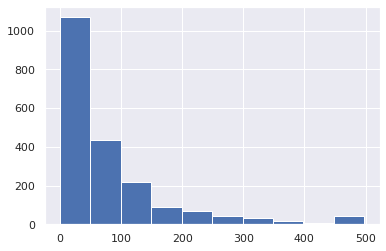

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(lengths.numpy())

In [2]:
# ---------------------------------
# YAHOO
yahoo_train_inputs, yahoo_train_atts = get_n_data_samples_x_y(
    language_dataset_name="yahoo_answer",
    image_or_language="language", 
    shuffle=False,
    N_samples=N_TRAIN_SAMPLES, 
    phase="train")

yahoo_valid_inputs, yahoo_valid_atts = get_n_data_samples_x_y(
    language_dataset_name="yahoo_answer",
    image_or_language="language", 
    shuffle=False,
    N_samples=N_VALID_CONDITIONAL_SAMPELS, 
    phase="valid")

yahoo_valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(yahoo_valid_inputs, yahoo_valid_atts), 
                                batch_size=COND_SAMPLE_BATCH_SIZE, pin_memory=True)

# ---------------------------------
# PTB
ptb_train_inputs, ptb_train_atts = get_n_data_samples_x_y(
    language_dataset_name="ptb",
    image_or_language="language", 
    shuffle=False,
    N_samples=N_TRAIN_SAMPLES, 
    phase="train")

ptb_valid_inputs, ptb_valid_atts = get_n_data_samples_x_y(
    language_dataset_name="ptb",
    image_or_language="language", 
    shuffle=False,
    N_samples=N_VALID_CONDITIONAL_SAMPELS, 
    phase="valid")

ptb_valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(ptb_valid_inputs, ptb_valid_atts), 
                                batch_size=COND_SAMPLE_BATCH_SIZE, pin_memory=True)

# ---------------------------------
# ALL TOGETHER
all_loaders = dict(yahoo=yahoo_valid_loader, ptb=ptb_valid_loader)


Is file!
train 140000
validation 6000
test 6000
Returns concatted input_ids, attention_masks tensors
Is file!
train 140000
validation 6000
test 6000
Returns concatted input_ids, attention_masks tensors
Is file!
train 42068
validation 3370
test 3761
Returns concatted input_ids, attention_masks tensors
Is file!
train 42068
validation 3370
test 3761
Returns concatted input_ids, attention_masks tensors


In [3]:
def get_length_of_chunk(chunk, eos_token_id=2, bos_token=0, remove_start=False):
    lens = []
    for s_i in chunk.tolist():
        # if it is a weak decoder, the start token needs to be cut-off as well (if predicted)
        if s_i[0] == bos_token and remove_start:
            s_i = s_i[1:]
        length = s_i.index(eos_token_id) if eos_token_id in s_i else len(s_i)
        lens.append(length)
    return lens

In [4]:
ptb_valid_lens = get_length_of_chunk(ptb_valid_inputs, remove_start=True)
ptb_train_lens = get_length_of_chunk(ptb_train_inputs, remove_start=True)
yahoo_valid_lens = get_length_of_chunk(yahoo_valid_inputs, remove_start=True)
yahoo_train_lens = get_length_of_chunk(yahoo_train_inputs, remove_start=True)

1 62
1 62


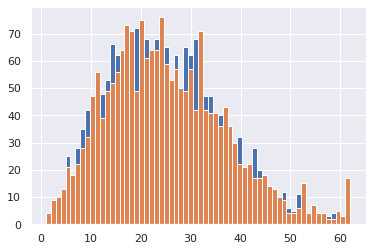

1 62
1 62


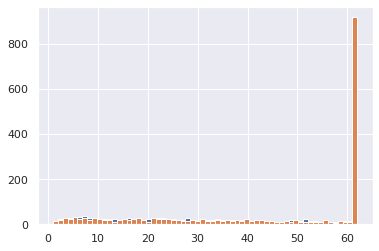

2000 2000
2000 2000
2000 2000
2000 2000


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print(min(ptb_valid_lens), max(ptb_valid_lens))
print(min(ptb_train_lens), max(ptb_train_lens))
plt.hist(ptb_valid_lens, bins=62)
plt.hist(ptb_train_lens, bins=62)
plt.show()

print(min(yahoo_valid_lens), max(yahoo_valid_lens))
print(min(yahoo_train_lens), max(yahoo_train_lens))
plt.hist(yahoo_valid_lens, bins=62)
plt.hist(yahoo_train_lens, bins=62)
plt.show()

print(len(ptb_valid_lens), len(ptb_valid_inputs))
print(len(ptb_train_lens), len(ptb_train_inputs))
print(len(yahoo_valid_lens), len(yahoo_valid_inputs))
print(len(yahoo_train_lens), len(yahoo_train_inputs))

In [6]:
prefixes = ["(29-nov ptb-beta-vae)", "(29-nov yahoo-beta-vae)", "(29-nov drop yahoo-beta-vae)"]
overview_df = make_run_overview_df(prefixes, add_data_group=False)
overview_df

,objective,dataset,l_rate,dropout,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
yahoo_answer | drop-0.25 | BETA-VAE beta 0.5 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.250000,0.500000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.5] | ST...
yahoo_answer | drop-1 | BETA-VAE beta 0.1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,1,0.100000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.1] | ST...
yahoo_answer | drop-0.75 | BETA-VAE beta 0.1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.750000,0.100000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.1] | ST...
yahoo_answer | drop-0.5 | BETA-VAE beta 0.1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.500000,0.100000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.1] | ST...
yahoo_answer | drop-0.25 | BETA-VAE beta 0.1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.250000,0.100000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.1] | ST...
yahoo_answer | drop-1 | BETA-VAE beta 0 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,1,0,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.0] | ST...
yahoo_answer | drop-0.75 | BETA-VAE beta 0 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.750000,0,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.0] | ST...
yahoo_answer | drop-0.5 | BETA-VAE beta 0 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.500000,0,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.0] | ST...
yahoo_answer | drop-0.25 | BETA-VAE beta 0 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.250000,0,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.0] | ST...
yahoo_answer | drop-1 | BETA-VAE beta 1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,1,1,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=1.0] | ST...


In [7]:
all_conditional_samples = dict()
# all_conditional_samples = torch.load("all_conditional_samples_so_far.pt")

for clean_name, row in overview_df.iterrows():
    print(clean_name)
    
    if clean_name in all_conditional_samples:
        continue
    
    checkpoint_path = f"{CHECKPOINT_DIR}/{row.run_name}.pt"
    
    vae_model = load_checkpoint_model_for_eval(checkpoint_path, 
                                               map_location=DEVICE, 
                                               return_args=False).to(DEVICE)
    
    if "ptb" in clean_name:
        data_loader = all_loaders["ptb"]
    else:
        data_loader = all_loaders["yahoo"]
    
    all_conditional_samples[clean_name] = []
        
    for i, (input_ids, attention_mask) in enumerate(data_loader):
        print(f"{i:2d}/{len(data_loader)}", end="\r")

        x_in = (input_ids.to(DEVICE), attention_mask.to(DEVICE))
        
        with torch.no_grad():
            _, z_post = vae_model.inf_model(x_in=x_in, n_samples=1)

            # Conditional sampling
            # [Sx, Sz, B, L] -> [B, L]
            conditional_sample_x = vae_model.gen_model.sample_generative_model(z=z_post,
                                                                               Sx=1, Sz=1, return_z=False,
                                                                               device=DEVICE).squeeze(0).squeeze(0)

        all_conditional_samples[clean_name].append(conditional_sample_x)

    all_conditional_samples[clean_name] = torch.cat(all_conditional_samples[clean_name]).cpu()
        
        


yahoo_answer | drop-0.25 | BETA-VAE beta 0.5 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 5.34 | total_loss: 161.39 | mmd: 0.00 | elbo: -166.73 | distortion: 156.05 | kl_prior_post: 10.69 | mean_mean: -0.00 | std_across_x_mean: 0.31 | std_across_z_mean: 0.35 | mean_scale: 0.92 | std_across_x_scale: 0.04 | std_across_z_scale: 0.10 | 
yahoo_answer | drop-1 | BETA-VAE beta 0.1 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 5.07 | total_loss: 271.08 | mmd: 0.00 | elbo: -316.72 | distortion: 266.01 | kl_prior_post: 50.71 | mean_mean: -0.00 | std_across_x_mean: 0.49 | std_across_z_mean: 0.58 | mean_scale: 0.77 | std_across_x_scale: 0.05 | std_across_z_scale: 0.26 | 
yahoo_answer | drop-0.75 | BETA-VAE beta 0.1 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 8.82 | total_loss: 162.54 | mmd: 0.00 | elbo: -241.88 | distortion: 153.73 | kl_prior_post: 88.15 | mean_mean: -0.01 | std_across_x_mean: 0.75 | std_across_z_mean: 0.78 | mean_scale: 0.56 | std_across_x_scale: 0.10 | std_across_z_scale: 0.21 | 
yahoo_answer | drop-0.5 | BETA-VAE beta 0.1 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 9.53 | total_loss: 150.79 | mmd: 0.00 | elbo: -236.51 | distortion: 141.26 | kl_prior_post: 95.25 | mean_mean: 0.02 | std_across_x_mean: 0.77 | std_across_z_mean: 0.79 | mean_scale: 0.51 | std_across_x_scale: 0.12 | std_across_z_scale: 0.18 | 
yahoo_answer | drop-0.25 | BETA-VAE beta 0.1 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 9.43 | total_loss: 143.58 | mmd: 0.00 | elbo: -228.47 | distortion: 134.15 | kl_prior_post: 94.31 | mean_mean: -0.00 | std_across_x_mean: 0.78 | std_across_z_mean: 0.80 | mean_scale: 0.51 | std_across_x_scale: 0.12 | std_across_z_scale: 0.16 | 
yahoo_answer | drop-1 | BETA-VAE beta 0 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 0.00 | total_loss: 278.56 | mmd: 0.00 | elbo: -694.66 | distortion: 278.56 | kl_prior_post: 416.10 | mean_mean: 0.02 | std_across_x_mean: 0.71 | std_across_z_mean: 1.13 | mean_scale: 0.06 | std_across_x_scale: 0.04 | std_across_z_scale: 0.03 | 
yahoo_answer | drop-0.75 | BETA-VAE beta 0 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 0.00 | total_loss: 147.74 | mmd: 0.00 | elbo: -858.23 | distortion: 147.74 | kl_prior_post: 710.49 | mean_mean: -0.01 | std_across_x_mean: 0.64 | std_across_z_mean: 0.76 | mean_scale: 0.01 | std_across_x_scale: 0.01 | std_across_z_scale: 0.00 | 
yahoo_answer | drop-0.5 | BETA-VAE beta 0 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 0.00 | total_loss: 132.45 | mmd: 0.00 | elbo: -844.83 | distortion: 132.45 | kl_prior_post: 712.38 | mean_mean: -0.03 | std_across_x_mean: 0.59 | std_across_z_mean: 0.70 | mean_scale: 0.01 | std_across_x_scale: 0.01 | std_across_z_scale: 0.00 | 
yahoo_answer | drop-0.25 | BETA-VAE beta 0 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 0.00 | total_loss: 121.73 | mmd: 0.00 | elbo: -803.50 | distortion: 121.73 | kl_prior_post: 681.76 | mean_mean: -0.02 | std_across_x_mean: 0.58 | std_across_z_mean: 0.71 | mean_scale: 0.01 | std_across_x_scale: 0.01 | std_across_z_scale: 0.00 | 
yahoo_answer | drop-1 | BETA-VAE beta 1 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 3.16 | total_loss: 285.03 | mmd: 0.00 | elbo: -285.03 | distortion: 281.87 | kl_prior_post: 3.16 | mean_mean: 0.00 | std_across_x_mean: 0.04 | std_across_z_mean: 0.12 | mean_scale: 0.99 | std_across_x_scale: 0.02 | std_across_z_scale: 0.09 | 
yahoo_answer | drop-0.75 | BETA-VAE beta 1 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 7.35 | total_loss: 178.73 | mmd: 0.00 | elbo: -178.73 | distortion: 171.38 | kl_prior_post: 7.35 | mean_mean: -0.00 | std_across_x_mean: 0.22 | std_across_z_mean: 0.26 | mean_scale: 0.96 | std_across_x_scale: 0.02 | std_across_z_scale: 0.11 | 
yahoo_answer | drop-0.5 | BETA-VAE beta 1 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 3.23 | total_loss: 168.55 | mmd: 0.00 | elbo: -168.55 | distortion: 165.32 | kl_prior_post: 3.23 | mean_mean: -0.00 | std_across_x_mean: 0.19 | std_across_z_mean: 0.20 | mean_scale: 0.97 | std_across_x_scale: 0.02 | std_across_z_scale: 0.04 | 
yahoo_answer | drop-0.25 | BETA-VAE beta 1 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 0.50 | total_loss: 163.70 | mmd: 0.00 | elbo: -163.70 | distortion: 163.20 | kl_prior_post: 0.50 | mean_mean: 0.00 | std_across_x_mean: 0.08 | std_across_z_mean: 0.08 | mean_scale: 0.99 | std_across_x_scale: 0.01 | std_across_z_scale: 0.01 | 
yahoo_answer | drop-1 | BETA-VAE beta 0.5 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 4.44 | total_loss: 280.92 | mmd: 0.00 | elbo: -285.36 | distortion: 276.48 | kl_prior_post: 8.88 | mean_mean: 0.00 | std_across_x_mean: 0.18 | std_across_z_mean: 0.26 | mean_scale: 0.96 | std_across_x_scale: 0.02 | std_across_z_scale: 0.13 | 
yahoo_answer | drop-0.75 | BETA-VAE beta 0.5 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 9.59 | total_loss: 175.84 | mmd: 0.00 | elbo: -185.44 | distortion: 166.25 | kl_prior_post: 19.19 | mean_mean: -0.00 | std_across_x_mean: 0.34 | std_across_z_mean: 0.41 | mean_scale: 0.89 | std_across_x_scale: 0.04 | std_across_z_scale: 0.17 | 
yahoo_answer | drop-0.5 | BETA-VAE beta 0.5 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 7.99 | total_loss: 166.17 | mmd: 0.00 | elbo: -174.16 | distortion: 158.18 | kl_prior_post: 15.98 | mean_mean: 0.00 | std_across_x_mean: 0.36 | std_across_z_mean: 0.40 | mean_scale: 0.90 | std_across_x_scale: 0.05 | std_across_z_scale: 0.13 | 
yahoo_answer BETA-VAE beta 1.5 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 0.02 | total_loss: 159.71 | mmd: 0.00 | elbo: -159.71 | distortion: 159.69 | kl_prior_post: 0.01 | mean_mean: -0.00 | std_across_x_mean: 0.01 | std_across_z_mean: 0.01 | mean_scale: 0.99 | std_across_x_scale: 0.00 | std_across_z_scale: 0.00 | 
yahoo_answer BETA-VAE beta 1 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 0.05 | total_loss: 159.73 | mmd: 0.00 | elbo: -159.73 | distortion: 159.68 | kl_prior_post: 0.05 | mean_mean: 0.00 | std_across_x_mean: 0.02 | std_across_z_mean: 0.02 | mean_scale: 0.99 | std_across_x_scale: 0.01 | std_across_z_scale: 0.00 | 
yahoo_answer BETA-VAE beta 1.5 dec: Weak-M roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

log_p_l_z: -4.01 | log_p_x_z (without l): -266.66 | beta_kl: 5.30 | total_loss: 275.97 | mmd: 0.00 | elbo: -274.20 | distortion: 270.67 | kl_prior_post: 3.53 | mean_mean: 0.00 | std_across_x_mean: 0.04 | std_across_z_mean: 0.11 | mean_scale: 0.99 | std_across_x_scale: 0.01 | std_across_z_scale: 0.10 | 
yahoo_answer BETA-VAE beta 1 dec: Weak-M roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

log_p_l_z: -3.74 | log_p_x_z (without l): -259.89 | beta_kl: 6.37 | total_loss: 270.01 | mmd: 0.00 | elbo: -270.01 | distortion: 263.63 | kl_prior_post: 6.37 | mean_mean: 0.00 | std_across_x_mean: 0.08 | std_across_z_mean: 0.19 | mean_scale: 0.98 | std_across_x_scale: 0.01 | std_across_z_scale: 0.13 | 
yahoo_answer BETA-VAE beta 0.5 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 1.95 | total_loss: 159.14 | mmd: 0.00 | elbo: -161.09 | distortion: 157.19 | kl_prior_post: 3.90 | mean_mean: 0.00 | std_across_x_mean: 0.22 | std_across_z_mean: 0.23 | mean_scale: 0.96 | std_across_x_scale: 0.03 | std_across_z_scale: 0.03 | 
yahoo_answer BETA-VAE beta 0.5 dec: Weak-M roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

log_p_l_z: -3.11 | log_p_x_z (without l): -250.36 | beta_kl: 7.02 | total_loss: 260.49 | mmd: 0.00 | elbo: -267.50 | distortion: 253.47 | kl_prior_post: 14.03 | mean_mean: 0.00 | std_across_x_mean: 0.23 | std_across_z_mean: 0.31 | mean_scale: 0.94 | std_across_x_scale: 0.03 | std_across_z_scale: 0.17 | 
yahoo_answer BETA-VAE beta 0.1 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 8.54 | total_loss: 139.85 | mmd: 0.00 | elbo: -216.72 | distortion: 131.30 | kl_prior_post: 85.42 | mean_mean: -0.01 | std_across_x_mean: 0.76 | std_across_z_mean: 0.78 | mean_scale: 0.53 | std_across_x_scale: 0.12 | std_across_z_scale: 0.15 | 
yahoo_answer BETA-VAE beta 0.1 dec: Weak-M roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

log_p_l_z: -2.56 | log_p_x_z (without l): -225.18 | beta_kl: 6.38 | total_loss: 234.12 | mmd: 0.00 | elbo: -291.55 | distortion: 227.74 | kl_prior_post: 63.80 | mean_mean: 0.01 | std_across_x_mean: 0.58 | std_across_z_mean: 0.65 | mean_scale: 0.72 | std_across_x_scale: 0.06 | std_across_z_scale: 0.28 | 
yahoo_answer BETA-VAE beta 0 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 0.00 | total_loss: 115.74 | mmd: 0.00 | elbo: -815.19 | distortion: 115.74 | kl_prior_post: 699.45 | mean_mean: -0.01 | std_across_x_mean: 0.54 | std_across_z_mean: 0.62 | mean_scale: 0.00 | std_across_x_scale: 0.01 | std_across_z_scale: 0.00 | 
yahoo_answer BETA-VAE beta 0 dec: Weak-M roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

log_p_l_z: -2.18 | log_p_x_z (without l): -192.11 | beta_kl: 0.00 | total_loss: 194.29 | mmd: 0.00 | elbo: -963.95 | distortion: 194.29 | kl_prior_post: 769.66 | mean_mean: -0.00 | std_across_x_mean: 0.69 | std_across_z_mean: 0.85 | mean_scale: 0.00 | std_across_x_scale: 0.01 | std_across_z_scale: 0.00 | 
ptb BETA-VAE beta 1.5 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 0.01 | total_loss: 90.78 | mmd: 0.00 | elbo: -90.78 | distortion: 90.78 | kl_prior_post: 0.00 | mean_mean: -0.00 | std_across_x_mean: 0.00 | std_across_z_mean: 0.00 | mean_scale: 1.00 | std_across_x_scale: 0.00 | std_across_z_scale: 0.00 | 
ptb BETA-VAE beta 1.5 dec: Weak-M roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

log_p_l_z: -4.20 | log_p_x_z (without l): -152.04 | beta_kl: 3.12 | total_loss: 159.36 | mmd: 0.00 | elbo: -158.32 | distortion: 156.24 | kl_prior_post: 2.08 | mean_mean: -0.00 | std_across_x_mean: 0.06 | std_across_z_mean: 0.11 | mean_scale: 0.99 | std_across_x_scale: 0.00 | std_across_z_scale: 0.07 | 
ptb BETA-VAE beta 1 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 0.02 | total_loss: 90.71 | mmd: 0.00 | elbo: -90.71 | distortion: 90.70 | kl_prior_post: 0.02 | mean_mean: 0.00 | std_across_x_mean: 0.01 | std_across_z_mean: 0.01 | mean_scale: 0.99 | std_across_x_scale: 0.00 | std_across_z_scale: 0.00 | 
ptb BETA-VAE beta 1 dec: Weak-M roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

log_p_l_z: -4.21 | log_p_x_z (without l): -147.61 | beta_kl: 3.90 | total_loss: 155.72 | mmd: 0.00 | elbo: -155.72 | distortion: 151.82 | kl_prior_post: 3.90 | mean_mean: -0.00 | std_across_x_mean: 0.07 | std_across_z_mean: 0.15 | mean_scale: 0.98 | std_across_x_scale: 0.01 | std_across_z_scale: 0.10 | 
ptb BETA-VAE beta 0.5 dec: Weak-M roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

log_p_l_z: -4.18 | log_p_x_z (without l): -140.51 | beta_kl: 4.49 | total_loss: 149.18 | mmd: 0.00 | elbo: -153.67 | distortion: 144.69 | kl_prior_post: 8.98 | mean_mean: -0.01 | std_across_x_mean: 0.06 | std_across_z_mean: 0.20 | mean_scale: 0.97 | std_across_x_scale: 0.01 | std_across_z_scale: 0.16 | 
ptb BETA-VAE beta 0.5 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 1.06 | total_loss: 90.38 | mmd: 0.00 | elbo: -91.44 | distortion: 89.32 | kl_prior_post: 2.12 | mean_mean: -0.00 | std_across_x_mean: 0.13 | std_across_z_mean: 0.16 | mean_scale: 0.98 | std_across_x_scale: 0.02 | std_across_z_scale: 0.04 | 
ptb BETA-VAE beta 0.1 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 6.91 | total_loss: 74.56 | mmd: 0.00 | elbo: -136.76 | distortion: 67.65 | kl_prior_post: 69.11 | mean_mean: 0.00 | std_across_x_mean: 0.67 | std_across_z_mean: 0.73 | mean_scale: 0.62 | std_across_x_scale: 0.08 | std_across_z_scale: 0.19 | 
ptb BETA-VAE beta 0 dec: Strong roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

beta_kl: 0.00 | total_loss: 53.51 | mmd: 0.00 | elbo: -735.47 | distortion: 53.51 | kl_prior_post: 681.95 | mean_mean: -0.03 | std_across_x_mean: 0.58 | std_across_z_mean: 0.69 | mean_scale: 0.01 | std_across_x_scale: 0.01 | std_across_z_scale: 0.00 | 
ptb BETA-VAE beta 0 dec: Weak-M roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

log_p_l_z: -3.17 | log_p_x_z (without l): -84.56 | beta_kl: 0.00 | total_loss: 87.73 | mmd: 0.00 | elbo: -919.74 | distortion: 87.73 | kl_prior_post: 832.01 | mean_mean: -0.00 | std_across_x_mean: 0.63 | std_across_z_mean: 0.84 | mean_scale: 0.00 | std_across_x_scale: 0.01 | std_across_z_scale: 0.00 | 
ptb BETA-VAE beta 0.1 dec: Weak-M roBERTa


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializin

log_p_l_z: -3.96 | log_p_x_z (without l): -116.16 | beta_kl: 4.90 | total_loss: 125.02 | mmd: 0.00 | elbo: -169.15 | distortion: 120.12 | kl_prior_post: 49.03 | mean_mean: 0.01 | std_across_x_mean: 0.38 | std_across_z_mean: 0.51 | mean_scale: 0.80 | std_across_x_scale: 0.04 | std_across_z_scale: 0.29 | 


In [9]:
torch.save(all_conditional_samples, "all_conditional_samples_so_far.pt")       

In [12]:
import os
import torch

max_samples = -1

all_unconditional_samples = dict()

for i, (clean_name, row) in enumerate(overview_df.iterrows()):
    print(i, clean_name)
    
    save_dir = f"{ANALYSIS_DIR}/{row.run_name}"
    sample_file = f"{save_dir}/{SAMPLE_FILE}"
    
    if os.path.exists(sample_file):
        samples = torch.load(sample_file)
        all_unconditional_samples[clean_name] = samples["x"]

0 yahoo_answer | drop-0.25 | BETA-VAE beta 0.5 dec: Strong roBERTa
1 yahoo_answer | drop-1 | BETA-VAE beta 0.1 dec: Strong roBERTa
2 yahoo_answer | drop-0.75 | BETA-VAE beta 0.1 dec: Strong roBERTa
3 yahoo_answer | drop-0.5 | BETA-VAE beta 0.1 dec: Strong roBERTa
4 yahoo_answer | drop-0.25 | BETA-VAE beta 0.1 dec: Strong roBERTa
5 yahoo_answer | drop-1 | BETA-VAE beta 0 dec: Strong roBERTa
6 yahoo_answer | drop-0.75 | BETA-VAE beta 0 dec: Strong roBERTa
7 yahoo_answer | drop-0.5 | BETA-VAE beta 0 dec: Strong roBERTa
8 yahoo_answer | drop-0.25 | BETA-VAE beta 0 dec: Strong roBERTa
9 yahoo_answer | drop-1 | BETA-VAE beta 1 dec: Strong roBERTa
10 yahoo_answer | drop-0.75 | BETA-VAE beta 1 dec: Strong roBERTa
11 yahoo_answer | drop-0.5 | BETA-VAE beta 1 dec: Strong roBERTa
12 yahoo_answer | drop-0.25 | BETA-VAE beta 1 dec: Strong roBERTa
13 yahoo_answer | drop-1 | BETA-VAE beta 0.5 dec: Strong roBERTa
14 yahoo_answer | drop-0.75 | BETA-VAE beta 0.5 dec: Strong roBERTa
15 yahoo_answer | dro

In [17]:
all_model_sample_lens = dict(ptb=dict(), yahoo_answer=dict())

model_names = list(all_conditional_samples.keys())

for model_name in model_names:
    print(model_name)
    
    unconditional_samples = all_unconditional_samples[model_name][:N_UNCONDITIONAL_SAMPLES]
    conditional_samples = all_conditional_samples[model_name]
    
    # to avoid lens > 62 only get the reasonable predictions
    if "weak" in model_name.lower():
        unconditional_samples = unconditional_samples[:, 1:-1]
        conditional_samples = conditional_samples[:, 1:-1]
    else:
        unconditional_samples = unconditional_samples[:, :-1]
        conditional_samples = conditional_samples[:, :-1]
    
    print(conditional_samples.shape, unconditional_samples.shape)
    
    unconditional_lens = get_length_of_chunk(unconditional_samples, remove_start=False)
    conditional_lens = get_length_of_chunk(conditional_samples, remove_start=True)
    
    print(len(conditional_lens), len(unconditional_lens))
    
    if "ptb" in model_name.lower():
        all_model_sample_lens["ptb"][model_name] = dict(valid_conditional=conditional_lens, unconditional=unconditional_lens)
    else:
        all_model_sample_lens["yahoo_answer"][model_name] = dict(valid_conditional=conditional_lens, unconditional=unconditional_lens)

yahoo_answer | drop-0.25 | BETA-VAE beta 0.5 dec: Strong roBERTa
torch.Size([2000, 62]) torch.Size([2000, 62])
2000 2000
yahoo_answer | drop-1 | BETA-VAE beta 0.1 dec: Strong roBERTa
torch.Size([2000, 62]) torch.Size([2000, 62])
2000 2000
yahoo_answer | drop-0.75 | BETA-VAE beta 0.1 dec: Strong roBERTa
torch.Size([2000, 62]) torch.Size([2000, 62])
2000 2000
yahoo_answer | drop-0.5 | BETA-VAE beta 0.1 dec: Strong roBERTa
torch.Size([2000, 62]) torch.Size([2000, 62])
2000 2000
yahoo_answer | drop-0.25 | BETA-VAE beta 0.1 dec: Strong roBERTa
torch.Size([2000, 62]) torch.Size([2000, 62])
2000 2000
yahoo_answer | drop-1 | BETA-VAE beta 0 dec: Strong roBERTa
torch.Size([2000, 62]) torch.Size([2000, 62])
2000 2000
yahoo_answer | drop-0.75 | BETA-VAE beta 0 dec: Strong roBERTa
torch.Size([2000, 62]) torch.Size([2000, 62])
2000 2000
yahoo_answer | drop-0.5 | BETA-VAE beta 0 dec: Strong roBERTa
torch.Size([2000, 62]) torch.Size([2000, 62])
2000 2000
yahoo_answer | drop-0.25 | BETA-VAE beta 0 dec

In [23]:
all_lens = {
    "ptb": {
        "data_group": dict(train=ptb_train_lens, valid=ptb_valid_lens),
        "model_groups": all_model_sample_lens["ptb"]},
    "yahoo_answer": {
        "data_group": dict(train=yahoo_train_lens, valid=yahoo_valid_lens),
        "model_groups": all_model_sample_lens["yahoo_answer"]}
}
torch.save(all_lens, "length_analysis_data.pt")